In [65]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from scipy.sparse import csr_matrix
import matplotlib as mpl
from scipy.integrate import quad
import numba
from scipy.integrate import solve_ivp

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward, central
from bachelor_funcs import get_first_dev
from ODE_schemes import A_matrix_regular, stencil_calc

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [66]:
# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

In [67]:
N = 1000
r_log = np.logspace(-2, 2, N)

[Text(0, 0.5, 'Δr'), Text(0.5, 0, 'r')]

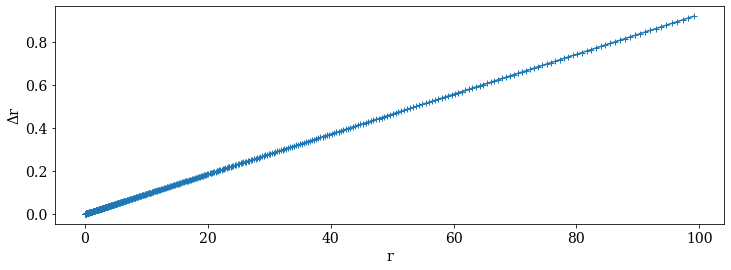

In [68]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(r_log[:-1], np.diff(r_log), ls = '-', marker = '+')
axs.set(ylabel='Δr', xlabel='r')

In [69]:
# Inital surface density:
def Σ_initial(r, γ = 1):
    return (3 * np.pi * r**γ)**(-1) * np.exp(-r**(2 - γ))

C = 1 / quad(Σ_initial, r_log[0], r_log[-1])[0]


def Σ_initial_norm(r, γ = 1):
    return C * Σ_initial(r, γ)

In [70]:
Δr = np.diff(r_log)
r_ghost = np.concatenate((np.array([r_log[0] - Δr[0]]), r_log, np.array([r_log[-1] + Δr[-1]])))
r_ghost2 = np.concatenate((np.array([r_log[0] - Δr[0]]), r_log))
len(r_ghost2)

1001

In [71]:
N_ghost = len(r_ghost)
s = 3

i1 = 0
i2 = s
A_ghost = np.zeros((N_ghost, N_ghost))
for i in range(N_ghost):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r_ghost[i1:i2] - r_ghost[i]
    coeff = stencil_calc(stencil, 1)
    A_ghost[i, i1:i2] = coeff
A_ghost[0] = 0
A_ghost[0, 0] = 1
A_ghost[-1] = 0
A_ghost[-1, -1] = 1


#A_ghost[1] = 0
#A_ghost[1, 0 : 3] = np.array([-0.5, 0 , 0.5]) / Δr[0]
#A_ghost[-2] = 0
#A_ghost[-2, -3:] = np.array([-0.5, 0 , 0.5]) / Δr[-1]

sA_ghost = csr_matrix(A_ghost.copy())

In [72]:
A_ghost

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.39829076e+03,  0.00000000e+00,  5.39829076e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -5.42317551e+03,  9.90822810e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.65216095e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.76721435e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

### Only imposing boundary condition at $r_{in}$

In [73]:
N_ghost2 = len(r_ghost2)
s = 5

i1 = 0
i2 = s
A_ghost2 = np.zeros((N_ghost2, N_ghost2))
for i in range(N_ghost2):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r_ghost2[i1:i2] - r_ghost[i]
    coeff = stencil_calc(stencil, 1)
    A_ghost2[i, i1:i2] = coeff
A_ghost2[0] = 0
A_ghost2[0, 0] = 1

A_ghost2[1] = 0
A_ghost2[1, 0 : 3] = np.array([-0.5, 0 , 0.5]) / Δr[0]

sA_ghost2 = csr_matrix(A_ghost2.copy())

In [74]:
N_log = len(r_log)
s = 3

i1 = 0
i2 = s
A_log = np.zeros((N_log, N_log))
for i in range(N_log):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r_log[i1:i2] - r_log[i]
    coeff = stencil_calc(stencil, 1)
    A_log[i, i1:i2] = coeff
sA_log = csr_matrix(A_log.copy())

In [75]:
def new_bound_ghost(t, Σ):
#Σ = Σ_initial_norm(r_log)

    inner = r_log**(1) * Σ * r_log**(1/2)
    ghost_1 = np.array([inner[1]])
    ghost_2 = np.array([inner[-2]])

    inner_ghost = np.concatenate((ghost_1, inner, ghost_2))

    outer_ghost = r_ghost**(1/2) * (sA_ghost @ inner_ghost) 

    sec_dev = 3 / r_ghost * (sA_ghost @ outer_ghost)

    return sec_dev[1: -1]

In [76]:
def boundin_ghost(t, Σ):
#Σ = Σ_initial_norm(r_log)

    inner = Σ * r_log**(3/2)
    ghost_1 = np.array([inner[1]])

    inner_ghost = np.concatenate((ghost_1, inner))

    outer_ghost = r_ghost2**(1/2) * (sA_ghost2 @ inner_ghost) 

    sec_dev = 3 / r_ghost2 * (sA_ghost2 @ outer_ghost)

    return sec_dev[1: ]

In [77]:
def only_log(t, Σ):
    inner = r_log**(1) * Σ * r_log**(1/2)

    outer = r_log**(1/2) * (sA_log @ inner)

    return 3 / r_log * (sA_log @ outer)

In [78]:
def only_log2(t, Σ):
    inner = r_log * Σ * r_log**(1/2)

    inner_dev = A_log @ inner
    outer_dev = A_log @ (r_log**(1/2) * inner_dev)

    return 3/r_log * outer_dev

In [79]:
γ = 1
t_s = (3 * (2 - γ)**2)**(-1)

t_func = lambda T, ts: (T - 1) * ts
T_func = lambda t, ts: t / ts + 1

Tspan = np.array([1, 2, 4, 8])
tspan = t_func(Tspan, t_s)
print(tspan, Tspan)
initial_state = Σ_initial_norm(r_log)

[0.         0.33333333 1.         2.33333333] [1 2 4 8]


In [80]:
sol_ghost = solve_ivp(new_bound_ghost, [tspan[0], tspan[-1]], initial_state, t_eval = tspan, method = 'LSODA', atol=1e-2, rtol=1e-4)

In [81]:
sol_ghost2 = solve_ivp(boundin_ghost, [tspan[0], tspan[-1]], initial_state, t_eval = tspan, method = 'LSODA', atol=1e-2, rtol=1e-4)

In [82]:
sol_log =  solve_ivp(only_log2, [tspan[0], tspan[-1]], initial_state, t_eval = tspan, method = 'LSODA', atol=1e-2, rtol=1e-4)

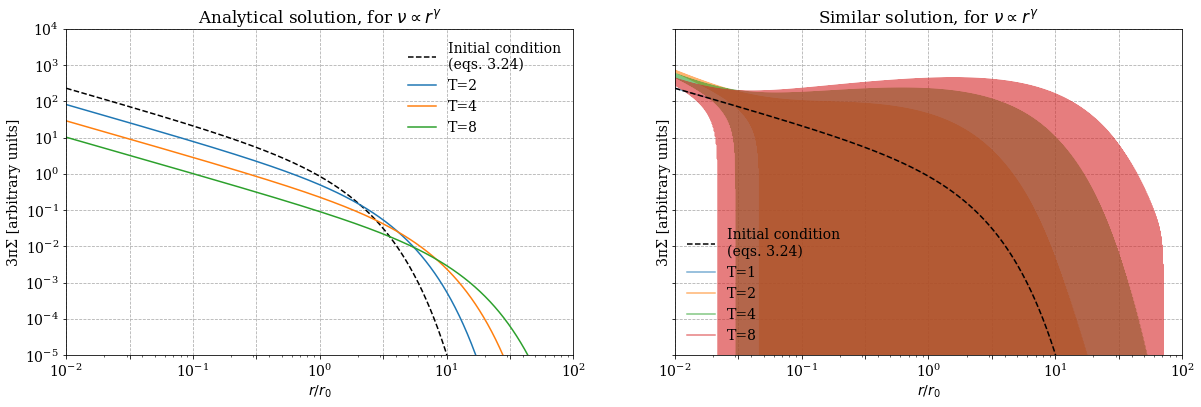

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey = True) 
### Analytical solution ###
axs[0].grid(ls='--')

axs[0].loglog(r_log, (3 * np.pi) * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)',  c='black', ls='--', zorder=2)

for T in Tspan[1:]:
    axs[0].loglog(r_log,  3 * np.pi * Σ(r_log, T), label=f'T={T}')
axs[0].legend(frameon = False)

axs[0].set(title='Analytical solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ [arbitrary units]', 
ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9));

### Numerical solution ###
axs[1].grid(ls='--')

axs[1].loglog(r_log, 3 * np.pi * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)',  c='black', ls='--', zorder=4)
for τ in tspan:#[1:-1]:
    axs[1].loglog(r_log, 3 * np.pi * sol_ghost.y[:, sol_ghost.t == τ], label=f'T={T_func(τ, t_s):1.0f}' , alpha = 0.6)

axs[1].set(title='Similar solution, for $ν \propto r^γ$', ylabel='3πΣ [arbitrary units]', 
xlabel='$r/r_0$', ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9))
axs[1].legend(frameon=False)

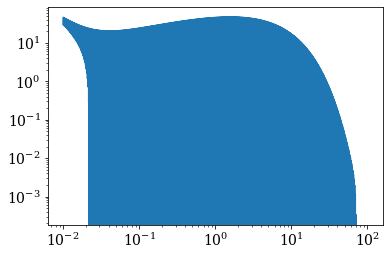

In [84]:
plt.loglog(r_log, sol_ghost.y[:,-1])
#sol_ghost.y[:,0]

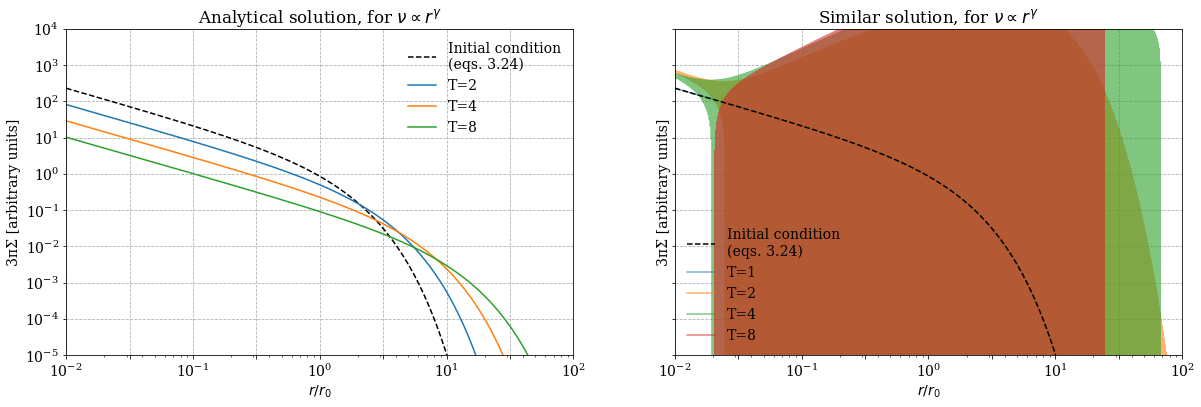

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey = True) 
### Analytical solution ###
axs[0].grid(ls='--')

axs[0].loglog(r_log, (3 * np.pi) * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)',  c='black', ls='--', zorder=2)

for T in Tspan[1:]:
    axs[0].loglog(r_log,  3 * np.pi * Σ(r_log, T), label=f'T={T}')
axs[0].legend(frameon = False)

axs[0].set(title='Analytical solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ [arbitrary units]', 
ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9));

### Numerical solution ###
axs[1].grid(ls='--')

axs[1].loglog(r_log, 3 * np.pi * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)',  c='black', ls='--', zorder=4)
for τ in tspan:#[1:-1]:
    axs[1].loglog(r_log, 3 * np.pi * sol_ghost2.y[:, sol_ghost2.t == τ], label=f'T={T_func(τ, t_s):1.0f}' , alpha = 0.6)

axs[1].set(title='Similar solution, for $ν \propto r^γ$', ylabel='3πΣ [arbitrary units]', 
xlabel='$r/r_0$', ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9))
axs[1].legend(frameon=False)

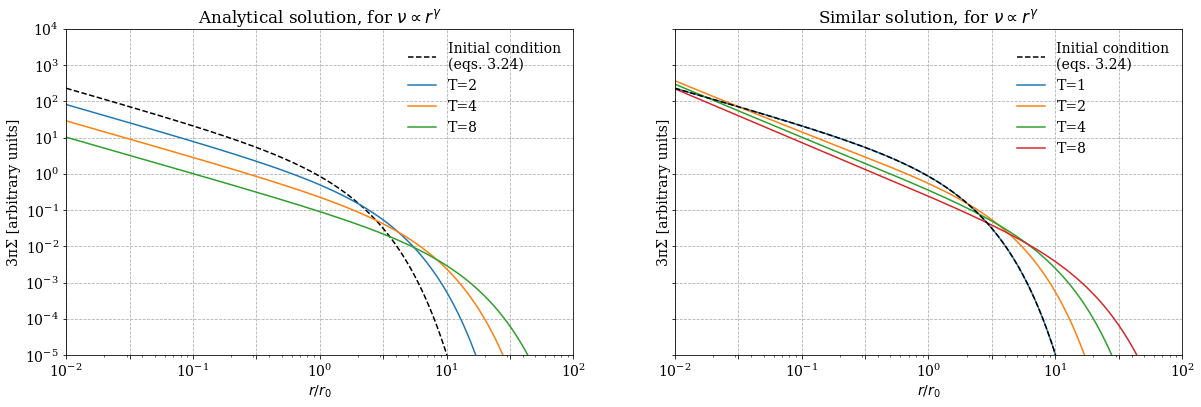

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey = True) 
### Analytical solution ###
axs[0].grid(ls='--')

axs[0].loglog(r_log, (3 * np.pi) * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)',  c='black', ls='--', zorder=2)

for T in Tspan[1:]:
    axs[0].loglog(r_log,  3 * np.pi * Σ(r_log, T), label=f'T={T}')
axs[0].legend(frameon = False)

axs[0].set(title='Analytical solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ [arbitrary units]', 
ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9));

### Numerical solution ###
axs[1].grid(ls='--')

axs[1].loglog(r_log, 3 * np.pi * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)',  c='black', ls='--', zorder=4)
for τ in tspan:#[1:-1]:
    axs[1].loglog(r_log, 3 * np.pi * sol_log.y[:, sol_log.t == τ], label=f'T={T_func(τ, t_s):1.0f}')

axs[1].set(title='Similar solution, for $ν \propto r^γ$', ylabel='3πΣ [arbitrary units]', 
xlabel='$r/r_0$', ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9))
axs[1].legend(frameon=False)